## MLSP Project: ScLimbic

#### By Gatien Caillet & Marc-André Sergiel

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

### Loading volumes

We load the volumes that are the output of the ScLimbic program.

In [2]:
df = pd.read_csv("sclimbic_output/sclimbic_volumes_all.csv")

In [3]:
df.head()

,case,Left-Nucleus-Accumbens,Right-Nucleus-Accumbens,Left-HypoThal-noMB,Right-HypoThal-noMB,Left-Fornix,Right-Fornix,Left-MammillaryBody,Right-MammillaryBody,Left-Basal-Forebrain,Right-Basal-Forebrain,Left-SeptalNuc,Right-SeptalNuc,eTIV
0,sub-561230PV_ses-1_T1w,391.3532,425.0864,432.7347,447.6708,494.8329,581.6072,62.3889,66.3118,325.8429,360.5298,120.6973,122.6665,1.037198e+06
1,sub-561230PV_ses-2_T1w,251.3988,270.1646,372.7118,394.6465,374.7776,335.2044,54.6505,70.3596,251.2069,291.1911,108.3337,102.6719,1.279477e+06
2,sub-561230PV_ses-3_T1w,171.9109,194.6711,342.3278,356.0924,212.6339,255.5058,46.0859,61.7726,157.5003,228.8239,90.5745,86.4208,1.300733e+06
3,sub-570226LD_ses-1_T1w,300.4666,318.6597,439.6470,427.5719,405.9556,362.2469,58.7780,65.1289,344.9737,373.4046,105.4529,98.2306,1.366261e+06
4,sub-570226LD_ses-2_T1w,173.7347,187.0540,423.3690,424.0515,269.1702,265.5680,60.9708,65.0657,231.7649,287.4189,115.6659,98.9140,1.432902e+06


We can get a subject's volumes for each available session (from 1 to 3) by filtering rows:

In [4]:
df[df['case'].str.contains('sub-561230PV')]

,case,Left-Nucleus-Accumbens,Right-Nucleus-Accumbens,Left-HypoThal-noMB,Right-HypoThal-noMB,Left-Fornix,Right-Fornix,Left-MammillaryBody,Right-MammillaryBody,Left-Basal-Forebrain,Right-Basal-Forebrain,Left-SeptalNuc,Right-SeptalNuc,eTIV
0,sub-561230PV_ses-1_T1w,391.3532,425.0864,432.7347,447.6708,494.8329,581.6072,62.3889,66.3118,325.8429,360.5298,120.6973,122.6665,1.037198e+06
1,sub-561230PV_ses-2_T1w,251.3988,270.1646,372.7118,394.6465,374.7776,335.2044,54.6505,70.3596,251.2069,291.1911,108.3337,102.6719,1.279477e+06
2,sub-561230PV_ses-3_T1w,171.9109,194.6711,342.3278,356.0924,212.6339,255.5058,46.0859,61.7726,157.5003,228.8239,90.5745,86.4208,1.300733e+06


We begin by extracting the names of the subjects.

In [5]:
subject_names = [ case.split('_')[0] for case in df['case']]
subject_names = np.unique(subject_names)
subject_names, subject_names.shape

(array(['sub-561230PV', 'sub-570226LD', 'sub-571216AT', 'sub-580620CG',
        'sub-580714PF', 'sub-581002PR', 'sub-600130DC', 'sub-600506GH',
        'sub-600816JLS', 'sub-601224NLL', 'sub-610415JD', 'sub-610612HV',
        'sub-611230FJ', 'sub-620204BD', 'sub-620227JB', 'sub-620818NC',
        'sub-620830MF', 'sub-630418CM', 'sub-630527GT', 'sub-630618AF',
        'sub-640107GB', 'sub-640425SV', 'sub-640427PV', 'sub-650328MCG',
        'sub-660125HM', 'sub-660412LM', 'sub-661117OP', 'sub-670213PC',
        'sub-670806JPP', 'sub-671019NL', 'sub-680518AH', 'sub-680917AG',
        'sub-680930WD', 'sub-690408PM', 'sub-690510ND', 'sub-690526CR',
        'sub-691229DB', 'sub-710509KM', 'sub-720501GL', 'sub-731001LC',
        'sub-761229PN', 'sub-810305BB', 'sub-840909AD', 'sub-851225EM'],
       dtype='<U13'),
 (44,))

We then extract the names of the subjects who passed 1, 2 or 3 sessions

In [6]:
subjects = {}
for subject_name in subject_names:
    
    rows = df[df['case'].str.contains(subject_name)]
    #print('Subject: {}, Number of sessions: {}'.format(subject_name,rows.shape[0]))
    n_ses = rows.shape[0]
    if n_ses in subjects:
        subjects[n_ses].append(subject_name)
    else:
        subjects[n_ses] = [subject_name]

In [7]:
len(subjects[1]), len(subjects[2]), len(subjects[3])

(2, 13, 29)

We have a total of 44 subjects. We only study the 29 subjects for which we have 3 sessions.

For each subject, we compute a Linear Regression on the normalized volumes (diving by the EstimaTed Intracranial Volume).  
We also compute, for each region, the percentage of the subjects for which the volumes are decreasing. Indeed, if this is not the case, it means that the segmentation is not correct.

In [8]:
X = np.array([7,366/2,3*365]).reshape(-1,1)

regions_slopes = {region : dict() for region in list(df.columns[1:-1])}
regions_percent = {region : 0 for region in list(df.columns[1:-1])}
regions_cc = {region : 0 for region in list(df.columns[1:-1])} #represents the number of subjects with 3 MRI done
regions_c = {region : 0 for region in list(df.columns[1:-1])} #represents the number of subjects with 3 MRI done for which the volume is decreasing

    
for subject_name in subjects[3]:
    rows = df[df['case'].str.contains(subject_name)]
    for column, slopes_dict in regions_slopes.items():

        seq = rows[column]
        y = seq / rows['eTIV']
        is_decreasing = np.all(np.diff(np.flip(y)) >= 0)
        regions_cc[column] += 1
        if is_decreasing:
            regions_c[column] += 1
            reg = LinearRegression().fit(X, y)
            slopes_dict[subject_name] = reg.coef_[0]
        regions_percent[column] = regions_c[column]/regions_cc[column] * 100

In [9]:
print('On average, there are {}% of subjects who have a decreasing volume'.format(round(np.mean(np.array(list(regions_percent.values()))))))

On average, there are 32% of subjects who have a decreasing volume


### Correlation between the age/MOCA score and the volume decrease 

We load the database that was provided to us in order to get the age and the MOCA score at J7.

In [10]:
db = pd.read_excel("Database.xlsx")
age_dict = dict(zip("sub-" + db["ID_MRI"],db["AGE"]))
moca_j7_dict = dict(zip("sub-" + db["ID_MRI"],db["MOCA_SCORE_J7"]))

For each region, we plot the graph of the volume slope with respect to the age or to the MOCA result.

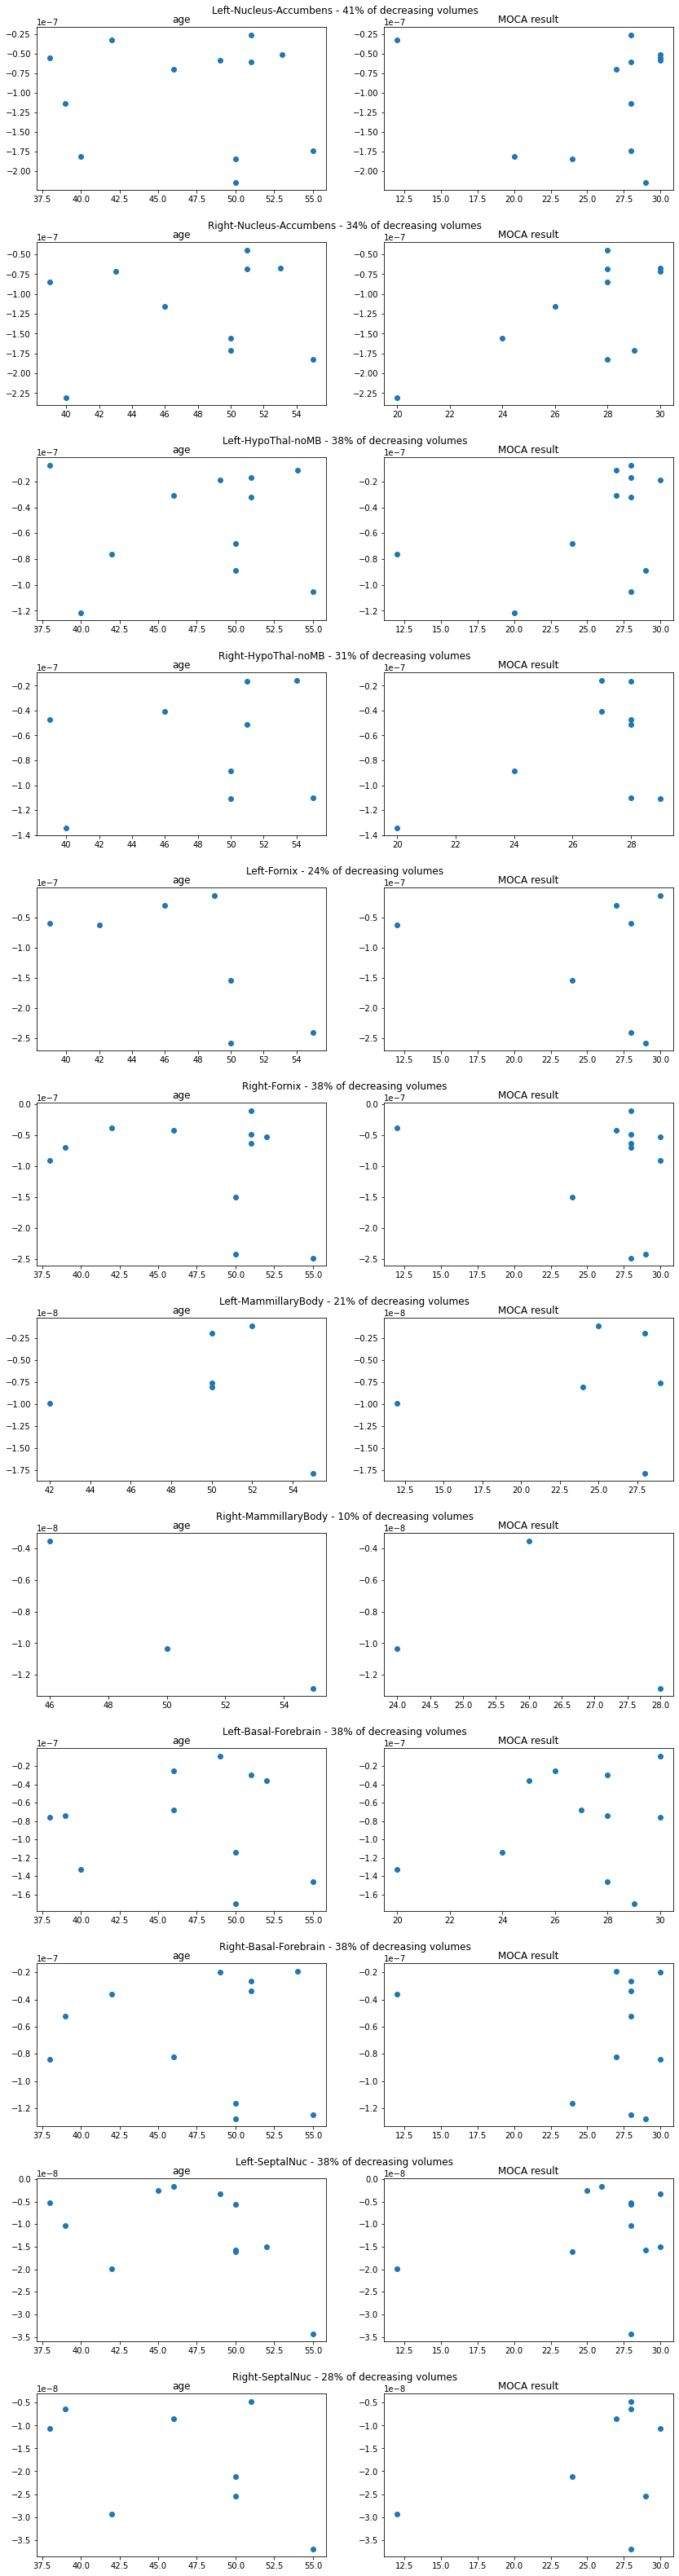

In [11]:
fig = plt.figure(figsize=(14,44))
i = 0
subfigs = fig.subfigures(nrows=len(regions_slopes), ncols=1)
for region in regions_slopes.keys():
    #plt.subplot(len(regions_slopes), 1, i+1)
    n = len(regions_slopes[region])
    ages = np.zeros(n)
    slopes = np.zeros(n)
    moca_j7 = np.zeros(n)
    for j, subject in enumerate(regions_slopes[region]):
        ages[j] = age_dict[subject]
        slopes[j] = regions_slopes[region][subject]
        moca_j7[j] = moca_j7_dict[subject]
    subfigs[i].suptitle("{} - {}% of decreasing volumes".format(region, round(regions_percent[region])))
    axs = subfigs[i].subplots(nrows = 1, ncols = 2)
    axs[0].scatter(ages, slopes)
    axs[0].set_title("age")
    axs[1].scatter(moca_j7, slopes)
    axs[1].set_title("MOCA result")
    i+= 1

We can clearly see that there is not any correlations present between the age/MOCA result and the decreasing speed of the volume.   
To be sure of this, we can also compute a Spearman correlation coefficient for these graph.

In [12]:
for region in regions_slopes.keys():
    ages = [age_dict[subject] for subject in regions_slopes[region].keys()]
    sp = spearmanr(ages, list(regions_slopes[region].values()))
    print("The Spearman correlation coefficient between the volume slope of the {} and the age of the subject is {} with a p-value of {}.".format(region, round(sp[0], 2),
                                                                                                                                                  round(sp[1], 2)))

The Spearman correlation coefficient between the volume slope of the Left-Nucleus-Accumbens and the age of the subject is 0.03 with a p-value of 0.93.
The Spearman correlation coefficient between the volume slope of the Right-Nucleus-Accumbens and the age of the subject is 0.26 with a p-value of 0.48.
The Spearman correlation coefficient between the volume slope of the Left-HypoThal-noMB and the age of the subject is -0.01 with a p-value of 0.97.
The Spearman correlation coefficient between the volume slope of the Right-HypoThal-noMB and the age of the subject is 0.24 with a p-value of 0.53.
The Spearman correlation coefficient between the volume slope of the Left-Fornix and the age of the subject is -0.61 with a p-value of 0.14.
The Spearman correlation coefficient between the volume slope of the Right-Fornix and the age of the subject is -0.07 with a p-value of 0.84.
The Spearman correlation coefficient between the volume slope of the Left-MammillaryBody and the age of the subject is

For the right mammillary body, we have a -1 correlation coefficient, meaning that the slope (corresponding to the decrease) is anticorrelated to the age: the older the patient, the smaller the decrease. However, due to the limited sample size, this could be an artefact.  
For the other regions, there doesn't seem to be any correlation.

We can do a similar thing for MOCA : 

In [13]:
for region in regions_slopes.keys():
    moca = [moca_j7_dict[subject] for subject in regions_slopes[region].keys()]
    sp = spearmanr(moca, list(regions_slopes[region].values()))
    print("The Spearman correlation coefficient between the volume slope of the {} and the MOCA score of the subject is {} with a p-value of {}.".format(region, round(sp[0], 2),
                                                                                                                                                         round(sp[1], 2)))

The Spearman correlation coefficient between the volume slope of the Left-Nucleus-Accumbens and the MOCA score of the subject is 0.2 with a p-value of 0.53.
The Spearman correlation coefficient between the volume slope of the Right-Nucleus-Accumbens and the MOCA score of the subject is 0.51 with a p-value of 0.13.
The Spearman correlation coefficient between the volume slope of the Left-HypoThal-noMB and the MOCA score of the subject is 0.28 with a p-value of 0.41.
The Spearman correlation coefficient between the volume slope of the Right-HypoThal-noMB and the MOCA score of the subject is 0.02 with a p-value of 0.96.
The Spearman correlation coefficient between the volume slope of the Left-Fornix and the MOCA score of the subject is 0.09 with a p-value of 0.85.
The Spearman correlation coefficient between the volume slope of the Right-Fornix and the MOCA score of the subject is -0.32 with a p-value of 0.34.
The Spearman correlation coefficient between the volume slope of the Left-Mammi

### Correlation between the age/MOCA score and the volume measured at the first session

For this experiment, we want also want to do a correlation analysis but for the estimated normalized volume corresponding to the first session. 

We first extract the results of each subject for this session.

In [14]:
regions_first = {region : dict() for region in list(df.columns[1:-1])}
for subject_name in subject_names:
    row = df[df['case'].str.contains(subject_name)].iloc[0]
    for region in row.index[1:-1]:
        regions_first[region][subject_name] = row[region]

Then we can plot the graph of the first volume with respect to the age or to the MOCA result.

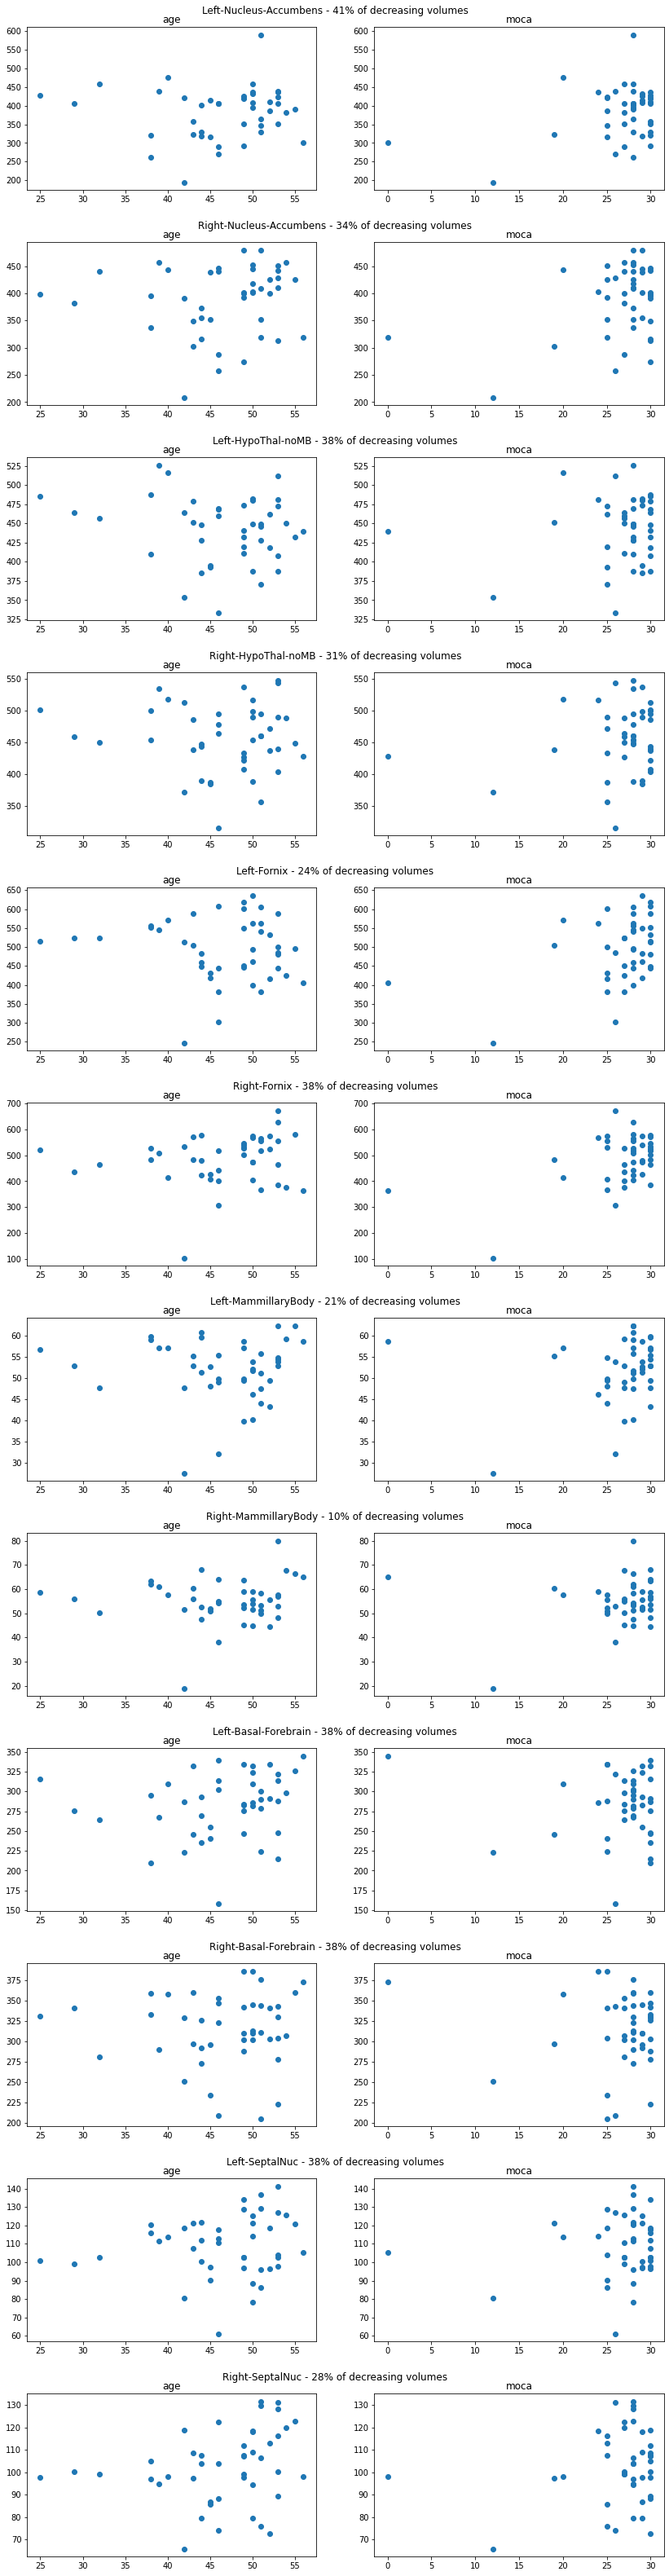

In [15]:
fig = plt.figure(figsize=(14,44))
i = 0
subfigs = fig.subfigures(nrows=len(regions_slopes), ncols=1)
for region in regions_slopes.keys():
    #plt.subplot(len(regions_slopes), 1, i+1)
    n = len(regions_first[region])
    ages = np.zeros(n)
    first = np.zeros(n)
    moca_j7 = np.zeros(n)
    for j, subject in enumerate(regions_first[region]):
        ages[j] = age_dict[subject]
        first[j] = regions_first[region][subject]
        moca_j7[j] = moca_j7_dict[subject]
    subfigs[i].suptitle("{} - {}% of decreasing volumes".format(region, round(regions_percent[region])))
    axs = subfigs[i].subplots(nrows = 1, ncols = 2)
    axs[0].scatter(ages, first)
    axs[0].set_title("age")
    axs[1].scatter(moca_j7, first)
    axs[1].set_title("moca")
    i+= 1

Spearman Correlation coefficients for age : 

In [16]:
for region in regions_first.keys():
    age = [age_dict[subject] for subject in regions_first[region].keys()]
    sp = spearmanr(age, list(regions_first[region].values()))
    print("The Spearman correlation coefficient between the volume of the {} and the age of the subject is {} with a p-value of {}.".format(region, round(sp[0], 2), 
                                                                                                                                            round(sp[1], 2)))

The Spearman correlation coefficient between the volume of the Left-Nucleus-Accumbens and the age of the subject is 0.08 with a p-value of 0.6.
The Spearman correlation coefficient between the volume of the Right-Nucleus-Accumbens and the age of the subject is 0.25 with a p-value of 0.1.
The Spearman correlation coefficient between the volume of the Left-HypoThal-noMB and the age of the subject is -0.14 with a p-value of 0.35.
The Spearman correlation coefficient between the volume of the Right-HypoThal-noMB and the age of the subject is -0.02 with a p-value of 0.88.
The Spearman correlation coefficient between the volume of the Left-Fornix and the age of the subject is -0.14 with a p-value of 0.37.
The Spearman correlation coefficient between the volume of the Right-Fornix and the age of the subject is 0.18 with a p-value of 0.25.
The Spearman correlation coefficient between the volume of the Left-MammillaryBody and the age of the subject is 0.02 with a p-value of 0.88.
The Spearman c

The volume of the right septal nuclei at the first session seems to be positively correlated (with a 0.35 coefficient) with the age: the older the patient, the higher the volume.  
Again, one should be careful since the number of subjects in the test is quite low.

For other regions, there doesn't seem to be any correlation.

Same for MOCA : 

In [17]:
for region in regions_first.keys():
    moca = [moca_j7_dict[subject] for subject in regions_first[region].keys()]
    sp = spearmanr(moca, list(regions_first[region].values()))
    print("The Spearman correlation coefficient between the volume of the {} and the MOCA score of the subject is {} with a p-value of {}.".format(region, round(sp[0], 2),
                                                                                                                                                   round(sp[1], 2)))

The Spearman correlation coefficient between the volume of the Left-Nucleus-Accumbens and the MOCA score of the subject is 0.11 with a p-value of 0.46.
The Spearman correlation coefficient between the volume of the Right-Nucleus-Accumbens and the MOCA score of the subject is 0.08 with a p-value of 0.6.
The Spearman correlation coefficient between the volume of the Left-HypoThal-noMB and the MOCA score of the subject is 0.07 with a p-value of 0.64.
The Spearman correlation coefficient between the volume of the Right-HypoThal-noMB and the MOCA score of the subject is 0.11 with a p-value of 0.49.
The Spearman correlation coefficient between the volume of the Left-Fornix and the MOCA score of the subject is 0.29 with a p-value of 0.06.
The Spearman correlation coefficient between the volume of the Right-Fornix and the MOCA score of the subject is 0.26 with a p-value of 0.09.
The Spearman correlation coefficient between the volume of the Left-MammillaryBody and the MOCA score of the subject

Again, there doesn't seem to be a strong correlation as all the p-values are above 0.05.